## Spam SMS Classification using LSTM

## 1. Import Libraries

In [1]:
import os
import warnings

import pandas as pd 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix

## 2. Ignore warnings

In [2]:
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

## 3. ● Read the data from the provided csv sms_spam_data.csv.

In [3]:
# Read dataset using pandas
df=pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Check info and shape of the data

In [4]:
#Rename columns names 
df = df.rename(columns={"v1":"LABEL", "v2":"SMS"})
df.head(2)

,LABEL,SMS,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN


In [5]:
#Checking the shape of the dataset
df.shape

(5572, 5)

In [6]:
#Checking info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   LABEL       5572 non-null   object
 1   SMS         5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Drop irrelevant columns

In [7]:
df = df[['LABEL','SMS']]

### Check frequency distribution of target column. Report whether the class is balanced or not?

ham     4825
spam     747
Name: LABEL, dtype: int64


,SMS
LABEL,
ham,4825
spam,747


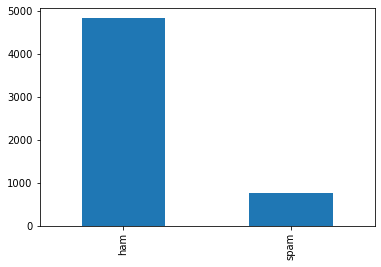

In [8]:
# #Number of observations in each label spam and ham
count = df.LABEL.value_counts()
print(count)
df.LABEL.value_counts().plot(kind = 'bar')
# Enable above 4 lines and plt graph as well
df.groupby(["LABEL"]).count()


Most are not 'spam'. The ratio is almost 1:6 in favor or class 'ham'.  The model's ability to predict class 'ham' will be better than predicting class 'spam'. 

We see that class is not balanced. Number of spam messages is less than number of normal messages

In [9]:
df.describe()

,LABEL,SMS
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
DFDuplicate = df[df.duplicated()]

In [11]:
#Checking value counts of dataframe having duplicate rows
DFDuplicate.LABEL.value_counts()

ham     309
spam     94
Name: LABEL, dtype: int64

In [12]:
DFDuplicate.head(30)
DFDuplicate.shape
#403 duplciate values present

(403, 2)

In [13]:
df = df.drop_duplicates()
df.shape

(5169, 2)

### Create a new column having length of the text message and see it’s distribution for the two classes ( ham and spam) and comment your findings.

In [14]:
df['length'] = df.SMS.apply(len)
df.head()

,LABEL,SMS,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [15]:
df.describe()

,length
count,5169.0000000
mean,78.9779454
std,58.2362932
min,2.0000000
25%,36.0000000
50%,60.0000000
75%,117.0000000
max,910.0000000


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

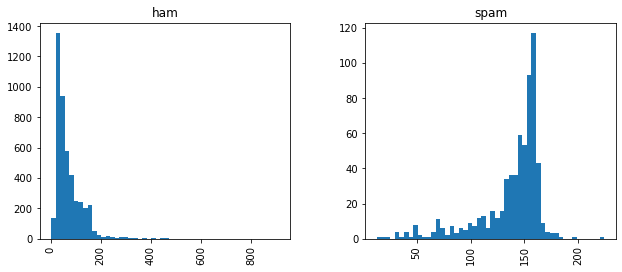

In [16]:
#Checking distribution of length for both the classes
df.hist(column='length', by='LABEL', bins=50,figsize=(10,4))

### This histogram is representation of number of times/frequency of how length of message is distributed in overall spectrum.  As can be seen that shorter messages are more when message is ham.Also ham message length is mostly located between 0 to 200, whereas it can be observed that the spam category of messages have mean length of 150 and most messages are at least of length 100 and more.

### Encode the label column and make it numerical

In [17]:
#Encode labels
df.loc[:,'LABEL'] = df.LABEL.map({'ham':0, 'spam':1})
print(df.shape)
df.head()

(5169, 3)


,LABEL,SMS,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [18]:
#Checking top 10 values of sms
df['SMS'].head(10)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: SMS, dtype: object

## Preprocess the text data to make it suitable for model building

### Convert the text message into lower case letters

In [19]:
df['SMS'] = df['SMS'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['SMS'].head()

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i don't think he goes to usf, he lives aro...
Name: SMS, dtype: object

### Remove punctuations

In [20]:
df['SMS'] = df['SMS'].str.replace('[^\w\s]','')
df['SMS'].head()

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: SMS, dtype: object

### Remove stop words from the text message

In [21]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words("english")
df['SMS'] = df['SMS'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['SMS'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nazrin.n\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
Name: SMS, dtype: object

In [22]:
#Checking frequency of words in the entire sms column and fetching top 10 frequencies
freq = pd.Series(' '.join(df['SMS']).split()).value_counts()[:10]
freq

u       1001
call     487
im       447
2        443
get      364
ur       316
go       269
dont     258
4        257
ltgt     254
dtype: int64

In [23]:
df = df[['SMS','LABEL']]

### Create feature vectors of the text data. [ hint - you can use any vectorizer or tokenizer]

In [24]:
max_features = 10000
maxlen = 25
embedding_size = 50

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['SMS']))
X = tokenizer.texts_to_sequences(df['SMS'])

print("Number of Samples:", len(X))       
print(X[0]) 

Number of Samples: 5169
[7, 3746, 623, 554, 591, 1025, 41, 56, 358, 1026, 76, 2470, 1027, 14, 3747, 65]


In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

X = pad_sequences(X, maxlen = maxlen)     
y = np.asarray(df['LABEL'])

print("Number of Labels: ", len(y))     
print(y[0])

Number of Labels:  5169
0


In [27]:
tokenizer.word_index

{'u': 1,
 'call': 2,
 'im': 3,
 '2': 4,
 'get': 5,
 'ur': 6,
 'go': 7,
 'dont': 8,
 '4': 9,
 'ltgt': 10,
 'ok': 11,
 'free': 12,
 'know': 13,
 'got': 14,
 'like': 15,
 'good': 16,
 'come': 17,
 'ill': 18,
 'time': 19,
 'want': 20,
 'day': 21,
 'love': 22,
 'text': 23,
 'send': 24,
 'going': 25,
 'one': 26,
 'need': 27,
 'lor': 28,
 'home': 29,
 'see': 30,
 'back': 31,
 'still': 32,
 'txt': 33,
 'r': 34,
 'stop': 35,
 'think': 36,
 'today': 37,
 'well': 38,
 'reply': 39,
 'tell': 40,
 'n': 41,
 'new': 42,
 'hi': 43,
 'da': 44,
 'ì': 45,
 'sorry': 46,
 'take': 47,
 'mobile': 48,
 'please': 49,
 'phone': 50,
 'hey': 51,
 'oh': 52,
 'much': 53,
 'cant': 54,
 'night': 55,
 'great': 56,
 'hope': 57,
 'week': 58,
 'later': 59,
 'claim': 60,
 'make': 61,
 'give': 62,
 'way': 63,
 'happy': 64,
 'wat': 65,
 'thats': 66,
 'already': 67,
 'dear': 68,
 'ask': 69,
 'number': 70,
 'work': 71,
 'yeah': 72,
 'pls': 73,
 'really': 74,
 'say': 75,
 'e': 76,
 'prize': 77,
 'right': 78,
 'tomorrow': 79,
 '

In [28]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

9431


In [29]:
EMBEDDING_FILE = 'glove.6B.50d.txt'
embeddings = {}
for o in open(EMBEDDING_FILE, encoding='utf8'):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 50))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [30]:
len(embeddings.values())

400001

In [31]:
num_words

9431

In [32]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(y.reshape(-1,1))

In [33]:
y = y.todense()

### Segregate the data into X (independent feature - text message) and y (label) and split the data into train and test set ( take test size = 0.30) (2 marks)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 50, stratify=y, test_size=0.3)

### Define a lstm model architecture using TensorFlow with an embedding and lstm layer followed by dense layers with activation as ReLu and sigmoid respectively.

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten
from functools import partial

model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation="sigmoid"))

### Compile the above model with loss as binary cross-entropy and optimizers ( like Adam or RMSro). Use accuracy as the metric for evaluation.

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['     '])

### Check the summary of the model. ( 2 marks)

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            471550    
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           183296    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3277312   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [38]:
print(X_train.shape, y_train.shape)

(3618, 25) (3618, 2)


In [39]:
print(X_test.shape, y_test.shape)

(1551, 25) (1551, 2)


### Fit the above lstm model on tokenized train data and check its performance on test data. Print the loss and accuracy for the test data.

In [40]:
batch_size = 100
epochs = 15

training_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Train on 3618 samples, validate on 1551 samples
Epoch 1/15
3618/3618 [==============================] - 9s 2ms/sample - loss: 0.1957 - accuracy: 0.9306 - val_loss: 0.1225 - val_accuracy: 0.9652
Epoch 2/15
3618/3618 [==============================] - 3s 852us/sample - loss: 0.0761 - accuracy: 0.9782 - val_loss: 0.1121 - val_accuracy: 0.9613
Epoch 3/15
3618/3618 [==============================] - 3s 854us/sample - loss: 0.0514 - accuracy: 0.9866 - val_loss: 0.1173 - val_accuracy: 0.9710
Epoch 4/15
3618/3618 [==============================] - 3s 874us/sample - loss: 0.0258 - accuracy: 0.9914 - val_loss: 0.1447 - val_accuracy: 0.9691
Epoch 5/15
3618/3618 [==============================] - 3s 907us/sample - loss: 0.0125 - accuracy: 0.9963 - val_loss: 0.1941 - val_accuracy: 0.9749
Epoch 6/15
3618/3618 [==============================] - 3s 860us/sample - loss: 0.0103 - accuracy: 0.9959 - val_loss: 0.1989 - val_accuracy: 0.9642
Epoch 7/15
3618/3618 [==============================] - 3s 852us/s

In [41]:
predictions = model.predict(X_test.reshape(len(X_test),25))

In [42]:
y_test_inv = enc.inverse_transform(y_test)

In [43]:
y_pred_inv = enc.inverse_transform(np.around(predictions))

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_inv, y_pred_inv)

array([[1331,   24],
       [  21,  175]], dtype=int64)

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_inv, y_pred_inv)

0.9709864603481625

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test_inv, y_pred_inv))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1355
           1       0.88      0.89      0.89       196

    accuracy                           0.97      1551
   macro avg       0.93      0.94      0.93      1551
weighted avg       0.97      0.97      0.97      1551



Text(0.5, 1.0, 'Training and validation loss')

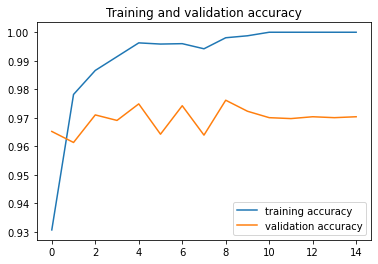

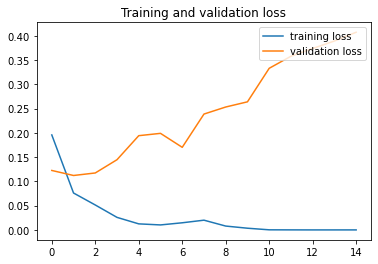

In [47]:
import matplotlib.pyplot as plt
accuracy      = training_history.history['accuracy']
val_accuracy  = training_history.history['val_accuracy']
loss     = training_history.history['loss']
val_loss = training_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss' )
plt.plot  ( epochs, val_loss, label = 'validation loss' )
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss'   )

## 6. Conclusion and Interpretation
### 1.) We get an overall accuracy of 98% in our model. F1 score is also quite high ~ 90% for both 0 and 1[ham and spam] class, which is quite good. 
### 2) LSTM model is able to accurately detect class 1 with F1 score and accuracy of ~ 90% is great considering the classes are imbalanced 

### 3.) Our mean precision value weighted average is 97%.